In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import talib
import sys
import os
sys.path.append(os.path.abspath(".."))  # if you're inside notebooks/

from scripts.news_utils import (
    load_news_data,
    parse_dates,
    filter_by_ticker,
    daily_article_counts,
    plot_daily_article_frequency
)

In [4]:
ticker = 'META'
news_path = '../data/raw_analyst_ratings.csv'
stock_path = f'../data/yfinance_data/{ticker}_historical_data.csv'

# ------------------ Load & Preprocess News Data ------------------
df_news = load_news_data(news_path)
df_news = parse_dates(df_news)
df_news_meta = filter_by_ticker(df_news, 'FB')

print("\nMETA News Data Info:")
print(df_news_meta.info())


META News Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 380 entries, 473873 to 474252
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   headline   380 non-null    object             
 1   url        380 non-null    object             
 2   publisher  380 non-null    object             
 3   date       380 non-null    datetime64[ns, UTC]
 4   stock      380 non-null    object             
 5   date_only  380 non-null    object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 20.8+ KB
None


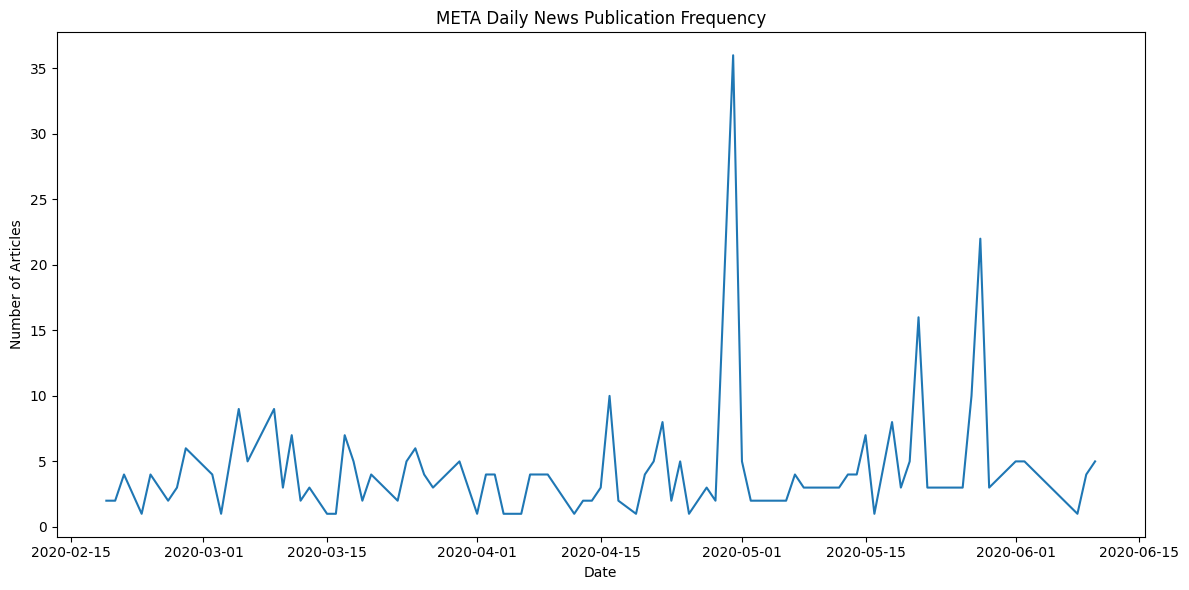

/tmp/ipykernel_5555/2473217095.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2020-06-10 20:20:19', '2020-06-10 19:25:13', '2020-06-10 15:33:26',
 '2020-06-10 04:52:01', '2020-06-10 04:28:00', '2020-06-09 16:14:26',
 '2020-06-09 16:09:42', '2020-06-09 15:36:51', '2020-06-09 14:08:00',
 '2020-06-08 09:54:23',
 ...
 '2020-02-24 00:00:00', '2020-02-23 00:00:00', '2020-02-21 00:00:00',
 '2020-02-21 00:00:00', '2020-02-21 00:00:00', '2020-02-21 00:00:00',
 '2020-02-20 00:00:00', '2020-02-20 00:00:00', '2020-02-19 00:00:00',
 '2020-02-19 00:00:00']
Length: 380, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  df_news_meta.loc[:, 'date'] = pd.to_datetime(df_news_meta['date'], utc=True).dt.tz_localize(None)



META Stock Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1119 entries, 2020-02-19 to 2024-07-30
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1119 non-null   float64
 1   High          1119 non-null   float64
 2   Low           1119 non-null   float64
 3   Close         1119 non-null   float64
 4   Adj Close     1119 non-null   float64
 5   Volume        1119 non-null   int64  
 6   Dividends     1119 non-null   float64
 7   Stock Splits  1119 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 78.7 KB
None


In [5]:
# ------------------ Visualize News Frequency ------------------
daily_counts = daily_article_counts(df_news_meta)
plot_daily_article_frequency(daily_counts, title=f'{ticker} Daily News Publication Frequency')

# ------------------ Load Stock Price Data ------------------
df_stock = pd.read_csv(stock_path)
df_news_meta.loc[:, 'date'] = pd.to_datetime(df_news_meta['date'], utc=True).dt.tz_localize(None)


df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.set_index('Date', inplace=True)
df_stock = df_stock[df_stock.index >= df_news_meta['date'].min()]  # Align with news

print("\nMETA Stock Data Info:")
print(df_stock.info())

In [6]:
# ------------------ Technical Indicators ------------------
df_stock['SMA_20'] = talib.SMA(df_stock['Close'], timeperiod=20)
df_stock['EMA_20'] = talib.EMA(df_stock['Close'], timeperiod=20)
df_stock['RSI'] = talib.RSI(df_stock['Close'], timeperiod=14)
df_stock['MACD'], df_stock['MACD_Signal'], df_stock['MACD_Hist'] = talib.MACD(
    df_stock['Close'], fastperiod=12, slowperiod=26, signalperiod=9
)

In [7]:
# ------------------ Financial Metrics ------------------
df_stock['Daily_Return'] = df_stock['Close'].pct_change() * 100
df_stock['Volatility'] = df_stock['Daily_Return'].rolling(window=20).std()


META with Indicators and Metrics:
                 Close      SMA_20        RSI  Daily_Return       MACD  \
Date                                                                     
2024-07-24  461.269989  502.223499  36.964279     -5.610922  -6.550694   
2024-07-25  453.410004  499.237999  34.814669     -1.703988  -8.810746   
2024-07-26  465.700012  496.545000  40.628601      2.710573  -9.500635   
2024-07-29  465.709991  494.619499  40.633231      0.002143  -9.932081   
2024-07-30  463.190002  492.545000  39.789373     -0.541107 -10.357947   

            MACD_Signal  MACD_Hist  
Date                                
2024-07-24    -1.274374  -5.276320  
2024-07-25    -2.781648  -6.029098  
2024-07-26    -4.125446  -5.375189  
2024-07-29    -5.286773  -4.645308  
2024-07-30    -6.301008  -4.056939  


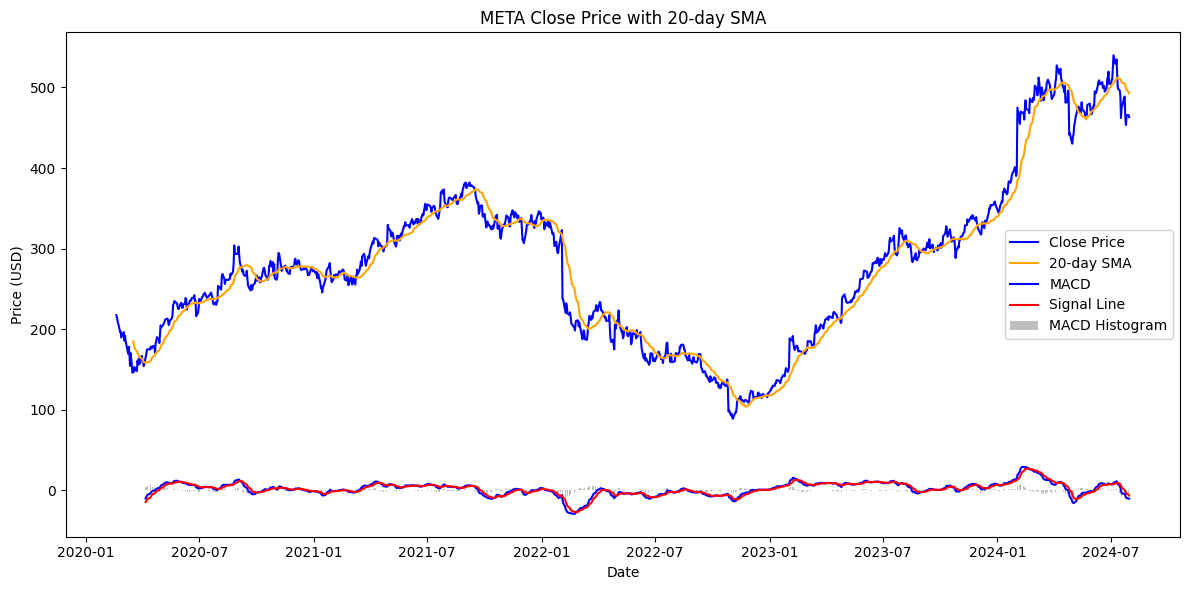

In [8]:
# ------------------ Inspect & Visualize ------------------
print("\nMETA with Indicators and Metrics:")
print(df_stock[['Close', 'SMA_20', 'RSI', 'Daily_Return', 'MACD', 'MACD_Signal', 'MACD_Hist']].tail())


# Plot Close Price with SMA
plt.figure(figsize=(12, 6))
plt.plot(df_stock['Close'], label='Close Price', color='blue')
plt.plot(df_stock['SMA_20'], label='20-day SMA', color='orange')
plt.plot(df_stock.index, df_stock['MACD'], label='MACD', color='blue')
plt.plot(df_stock.index, df_stock['MACD_Signal'], label='Signal Line', color='red')
plt.bar(df_stock.index, df_stock['MACD_Hist'], label='MACD Histogram', color='gray', alpha=0.5)


plt.title(f'{ticker} Close Price with 20-day SMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()